In [9]:
import casadi as ca
from scipy.special import binom
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from zipfile import ZipFile
import os
import datetime


class Bezier:
#https://en.wikipedia.org/wiki/B%C3%A9zier_curve

    def __init__(self, P: ca.SX, T: float):
        self.P = P
        self.m = P.shape[0]
        self.n = P.shape[1]-1
        self.T = T
    
    def eval(self, t):
        #https://en.wikipedia.org/wiki/De_Casteljau%27s_algorithm
        beta = t/self.T
        A = ca.SX(self.P)
        for j in range(1, self.n + 1):
            for k in range(self.n + 1 - j):
                A[:, k] = A[:, k] * (1 - beta) + A[:, k + 1] * beta
        return A[:, 0]
    
    def deriv(self, m=1):
        D = ca.SX(self.P)
        for j in range(0, m):
            D = (self.n - j)*ca.horzcat(*[ D[:, i+1] - D[:, i] for i in range(self.n - j) ])
        return Bezier(D/self.T**m, self.T)

** Note that the Bezier derivations and solutions are from "BezierCasadi.ipynb" file. This file work on derivations of multirotor_ref_traj

In [10]:
def derive_bezier6():
    n = 6
    T = ca.SX.sym('T')
    t = ca.SX.sym('t')
    P = ca.SX.sym('P', 1, n)
    B = Bezier(P, T)

    # derivatives
    B_d = B.deriv()
    B_d2 = B_d.deriv()
    B_d3 = B_d2.deriv()
    B_d4 = B_d3.deriv()

    # boundary conditions

    # trajectory
    p = B.eval(t)
    v = B_d.eval(t)
    a = B_d2.eval(t)
    j = B_d3.eval(t)
    s = B_d4.eval(t)
    r = ca.vertcat(p, v, a, j, s)

    # given position/velocity boundary conditions, solve for bezier points
    wp_0 = ca.SX.sym('p0', 2, 1)  # pos/vel at waypoint 0
    wp_1 = ca.SX.sym('p1', 2, 1)  # pos/vel at waypoint 1

    constraints = []
    constraints += [(B.eval(0), wp_0[0])]  # pos @ wp0
    constraints += [(B_d.eval(0), wp_0[1])]  # vel @ wp0
    constraints += [(B_d2.eval(0), 0)]  # zero accel @ wp0
    constraints += [(B.eval(T), wp_1[0])]  # pos @ wp1
    constraints += [(B_d.eval(T), wp_1[1])]  # vel @ wp1
    constraints += [(B_d2.eval(T), 0)]  # zero accel @ wp1

    assert len(constraints) == 6

    Y = ca.vertcat(*[c[0] for c in constraints])
    b = ca.vertcat(*[c[1] for c in constraints])
    A = ca.jacobian(Y, P)
    A_inv = ca.inv(A)
    P_sol = (A_inv@b).T
    return {
        'bezier6_solve': ca.Function('bezier6_solve', [wp_0, wp_1, T], [P_sol], ['wp_0', 'wp_1', 'T'], ['P']),
        'bezier6_traj': ca.Function('bezier6_traj', [t, T, P], [r], ['t', 'T', 'P'], ['r']),
    }

In [11]:
def derive_rover():
    n = 6
    bz = derive_bezier6()
    bezier_6_solve = bz['bezier6_solve']
    bezier_6_traj = bz['bezier6_traj']

    L = ca.SX.sym('L')  # wheel base
    T = ca.SX.sym('T')
    t = ca.SX.sym('t')

    PX = ca.SX.sym('PX', 1, n)
    PY = ca.SX.sym('PY', 1, n)
    traj_x = bezier_6_traj(t, T, PX)
    traj_y = bezier_6_traj(t, T, PY)

    x = traj_x[0]
    vx = traj_x[1]
    ax = traj_x[2]

    y = traj_y[0]
    vy = traj_y[1]
    ay = traj_y[2]

    psi = ca.arctan2(vy, vx)
    V = ca.sqrt(vx**2 + vy**2)
    omega = (vx*ay - vy*ax)/V
    delta = ca.atan(L*omega/V)

    return {
        'rover': ca.Function(
            'rover', [t, T, PX, PY, L], [x, y, psi, V, delta],
            ['t', 'T', 'PX', 'PY', 'L'], ['x', 'y', 'psi', 'V', 'delta']
        )
    }

rover = derive_rover()
rover['rover'](1, 4, [1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 3], 1)

(DM(0.237305), DM(0.477539), DM(-2.04196), DM(0.871305), DM(-0.0406785))

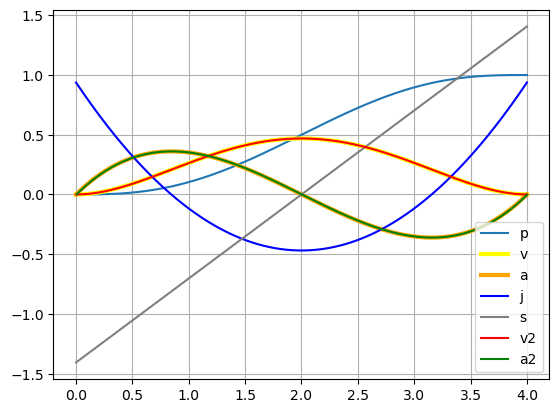

In [12]:
def test_bezier():
    # check bezier with numerical derivatives
    bezier_6= derive_bezier6()
    T0 = 4
    t0 = np.linspace(0, T0, 1000)
    P0 = bezier_6['bezier6_solve']([0, 0], [1, 0], T0)
    traj = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, P0)).T
    p = traj[:, 0]
    v = traj[:, 1]
    a = traj[:, 2]
    j = traj[:, 3]
    s = traj[:, 4]

    v2 = np.diff(p.reshape(-1), axis=0)/np.diff(t0, axis=0)
    a2 = np.diff(v2.reshape(-1), axis=0)/np.diff(t0[1:], axis=0)
    
    assert np.max(v[1:] - v2) < 1e-1
    assert np.max(a[2:] - a2) < 1e-1

    plt.plot(t0, p, label='p')
    plt.plot(t0, v, label='v', linewidth=3, color='yellow')
    plt.plot(t0, a, label='a', color='orange', linewidth=3)
    plt.plot(t0, j, label='j', color='blue')
    plt.plot(t0, s, label='s', color='grey')

    plt.plot(t0[1:], v2, label='v2', color='red')
    plt.plot(t0[2:], a2, label='a2', color='green')    
    plt.legend()
    plt.grid() 

test_bezier()


Added functions below

In [13]:
tol = 1e-4
g = 9.81
m = 1 # mass

def solve_multiRotor_dynamics(traj_x,traj_y,traj_z):
    #unit vector in body frame
    xh = ca.transpose(ca.SX([1, 0, 0]))
    yh = ca.transpose(ca.SX([0, 1, 0]))
    zh = ca.transpose(ca.SX([0, 0, 1]))

    #position, velocity, acceleration for derived curve
    px = traj_x[0]
    vx = traj_x[1]
    ax = traj_x[2]
    jx = traj_x[3]
    sx = traj_x[4]

    py = traj_y[0]
    vy = traj_y[1]
    ay = traj_y[2]
    jy = traj_y[3]
    sy = traj_y[4]

    pz = traj_z[0]
    vz = traj_z[1]
    az = traj_z[2]
    jz = traj_z[3]
    sz = traj_z[4]


    #flat output expressed in e frame
    p_e = ca.hcat([px, py, pz])
    v_e = ca.hcat([vx, vy, vz])
    a_e = ca.hcat([ax, ay, az])
    j_e = ca.hcat([jx, jy, jz])
    s_e = ca.hcat([sx, sy, sz])

    #Newton second law
    display(a_e)
    thrust_e = m * (g* zh - a_e)

    #check for singularity
    thrust = ca.if_else(thrust_e >tol, ca.norm_2(thrust_e), tol) #normalize thrust term
    zb_e = thrust_e / thrust

    #desired heading angle (desired yaw angle)
    psi_des = 0 #keep psi angle 0 wrt to camera frame #Recheck


    #desired heading direction
    xc_e = ca.cos(psi_des) * xh + ca.sin(psi_des) * yh

    yb_e = ca.cross(zb_e,xc_e)
    N_yb_e = ca.norm_2(yb_e)
    yb_e = ca.if_else(
        N_yb_e > tol, yb_e / N_yb_e, yh
    )  # normalize y_b, can have singularity when z_b and x_c aligned
    
    xb_e = ca.cross(yb_e, zb_e)  
    
    C_be =  ca.hcat([xb_e, yb_e, zb_e]) #C_be
    

    # #############################################################################################
    # # #Angular Velocity

    # # deriv of translational EOM wrt e frame
    # # note h_omega z_b component can be ignored with dot product below
    # t2_e = m / thrust * j_e
    # p = ca.dot(t2_e, yb_e)
    # q = -ca.dot(t2_e, xb_e)

    # C_eb = C_be.T

    # # solve for euler angles based on DCM
    # theta = ca.asin(-C_eb[2, 0])  # check if transpose
    # phi = ca.if_else(
    #     ca.fabs(ca.fabs(theta) - ca.pi / 2) < tol, 0, ca.atan2(C_eb[2, 1], C_eb[2, 2])
    # )

    # # solve for r
    # cos_phi = ca.cos(phi)
    # cos_phi = ca.if_else(ca.fabs(cos_phi) > tol, cos_phi, 0)
    # r = (
    #     -q * ca.tan(phi) + ca.cos(theta) * psi_dot / cos_phi  ####psi dot term?
    # )  # from R_solve below, singularity at phi=pi

    # T_dot = -ca.dot(m * j_e, zb_e) #FIX jerk term
    
    # omega_eb_b = p * xh + q * yh + r * zh    

    
    # ##############################################################################################

    # ## Angular Acceleration omega_dot_eb_b (from multirotor_ref_traj.py)
    # omega_eb_b_cross_zh = ca.cross(omega_eb_b, zh)

    # coriolis_b = 2 * T_dot / thrust * omega_eb_b_cross_zh
    # centrip_b = ca.cross(omega_eb_b, omega_eb_b_cross_zh)

    # q_dot = -m / thrust * ca.dot(s_e, xb_e) - ca.dot(coriolis_b, xh) - ca.dot(centrip_b, xh) 
    # p_dot = m / thrust * ca.dot(s_e, yb_e) + ca.dot(coriolis_b, yh) + ca.dot(centrip_b, yh)

    # omega_eb_e = C_be @ omega_eb_b
    # omega_ec_e = psi_dot * zh #FIX psi dot

    # theta_dot = (q - ca.sin(phi) * ca.cos(theta) * psi_dot) / ca.cos(phi) #FIX psi dot
    # phi_dot = p + ca.sin(theta) * psi_dot #FIX psi dot

    # zc_e = zh  # c frame rotates about ze so zc_c = zc_e = zh
    # yc_e = ca.cross(zc_e, xc_e)
    # T1 = ca.inv(ca.horzcat(xb_e, yc_e, zh))
    # A = T1 @ C_be
    # b = -T1 @ (
    #     ca.cross(omega_eb_e, phi_dot * xb_e) + ca.cross(omega_ec_e, theta_dot * yc_e)
    # )
    # r_dot = (psi_ddot - A[2, 0] * p_dot - A[2, 1] * q_dot - b[2]) / A[2, 2] #FIX psi ddot

    # omega_dot_eb_b = p_dot * xh + q_dot * yh + r_dot * zh

    # ##################################################################################################
    # # ## Solve for Inputs

    # if False:
    #     J = ca.SX(3, 3)
    #     J[0, 0] = J_xx
    #     J[1, 1] = J_yy
    #     J[2, 2] = J_zz
    #     J[0, 2] = J[2, 0] = J_xz

    #     M_b = J @ omega_dot_eb_b + ca.cross(omega_eb_b, J @ omega_eb_b)

    return C_be #, omega_eb_b, omega_dot_eb_b

    

In [14]:
# from notebooks.MultiRotorRefTraj 

In [15]:
def derive_multiRotor():
    n = 6
    bz = derive_bezier6()
    bezier_6_solve = bz['bezier6_solve']
    bezier_6_traj = bz['bezier6_traj']

    L = ca.SX.sym('L')  # wheel base
    T = ca.SX.sym('T') #Time t2
    t = ca.SX.sym('t') #Time t1

    m = ca.SX.sym('m') # mass of multiroter
    m= 1  #TEMP mass
    g = 9.81 #accel of gravity in m/s^2

    PX = ca.SX.sym('PX', 1, n)
    PY = ca.SX.sym('PY', 1, n)
    PZ = ca.SX.sym('PZ', 1, n)
    traj_x = bezier_6_traj(t, T, PX)
    traj_y = bezier_6_traj(t, T, PY)
    traj_z = bezier_6_traj(t, T, PZ)

    #unit vector in body frame
    xh = ca.SX([1, 0, 0]).T
    yh = ca.SX([0, 1, 0]).T
    zh = ca.SX([0, 0, 1]).T

    #position, velocity, acceleration for derived curve
    px = traj_x[0]
    vx = traj_x[1]
    ax = traj_x[2]
    jx = traj_x[3]
    sx = traj_x[4]

    py = traj_y[0]
    vy = traj_y[1]
    ay = traj_y[2]
    jy = traj_y[3]
    sy = traj_y[4]

    pz = traj_z[0]
    vz = traj_z[1]
    az = traj_z[2]
    jz = traj_z[3]
    sz = traj_z[4]


    #flat output expressed in e frame
    p_e = ca.hcat([px, py, pz])
    v_e = ca.hcat([vx, vy, vz])
    a_e = ca.hcat([ax, ay, az])
    j_e = ca.hcat([jx, jy, jz])
    s_e = ca.hcat([sx, sy, sz])

    #Newton second law
    thrust_e = m * (g* zh - a_e)
    #check for singularity
    thrust = ca.if_else(thrust_e >tol, ca.norm_2(thrust_e), tol)
    zb_e = thrust_e / thrust

    #desired heading angle (desired yaw angle)
    psi_des = ca.arctan2(vy, vx)                #recheck
 #read mellinger paper
 #psi is angle to camera unit vector
    

    #desired heading direction
    xc_e = ca.cos(psi_des) * xh + ca.sin(psi_des) * yh

    yb_e = ca.cross(zb_e,xc_e)
    N_yb_e = ca.norm_2(yb_e)
    yb_e = ca.if_else(
        N_yb_e > tol, yb_e / N_yb_e, yh
    )  # normalize y_b, can have singularity when z_b and x_c aligned
    
    xb_e = ca.cross(yb_e, zb_e)  
    
    C_be =  ca.vcat([xb_e, yb_e, zb_e]).T #C_be (originally hcat)

    return {
        'multiRotor': ca.Function(
            'multiRotor', [t, T, PX, PY, PZ], [px, py, pz, psi_des, C_be],
            ['t', 'T', 'PX', 'PY', 'PZ'], ['x', 'y', 'z', 'psi', 'C_be']
        )
    }

multiRotor = derive_multiRotor()
output = multiRotor['multiRotor'](1, 4, [1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0])
output

(DM(0.237305),
 DM(0.474609),
 DM(0.395508),
 DM(-2.03444),
 DM(
 [[-0.444332, 0.894427, -5273.44], 
  [-0.888664, -0.447214, -10546.9], 
  [-11791.8, 0, 0.993557]]))

2.3151252777563114

array([1, 1])

array([2, 0])

DM([[1, 1.46303, 1.92605, 2, 2, 2]])

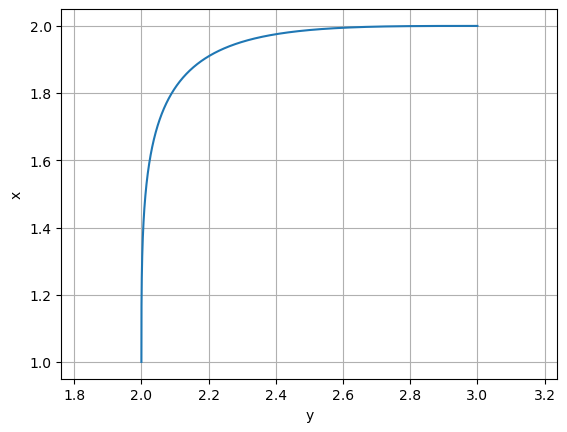

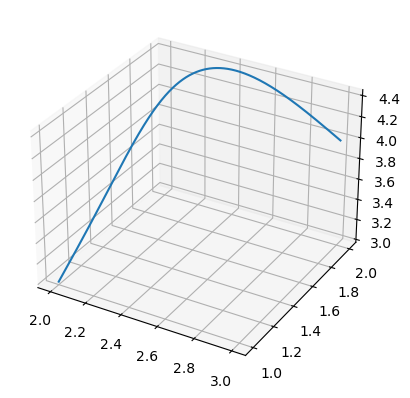

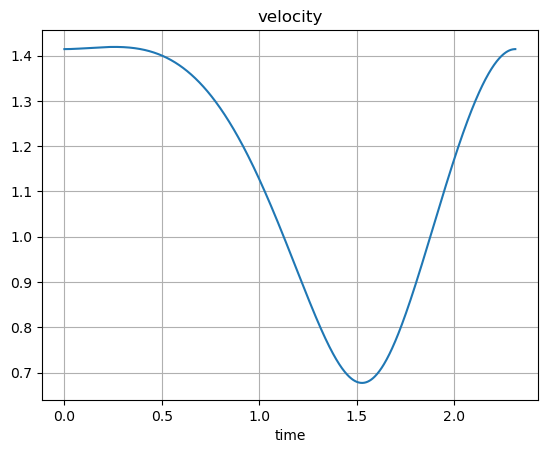

In [19]:
def multiRotor_plan():
    T0 = 2.3151252777563114  ##Use optimized time from "dev-Bezier_FindOptimizeFunc.ipynb"
    bezier_6 = derive_bezier6()

    bc = np.array([
        [ # position
            [1, 2, 3],  # wp0, x, y, z
            [2, 3, 4]   # wp1, x, y, z
        ],
        [ # velocity
            [1, 0, 1],
            [0, 1, -1]
        ]
    ])

    t0 = np.linspace(0, T0, 1000)
    display(T0)
    display(bc[:,0,0])
    display(bc[:,0,1])

    PX = bezier_6['bezier6_solve'](bc[:, 0, 0], bc[:, 1, 0], T0)
    display(PX)
    traj_x = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, PX)).T

    PY = bezier_6['bezier6_solve'](bc[:, 0, 1], bc[:, 1, 1], T0)
    traj_y = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, PY)).T

    PZ = bezier_6['bezier6_solve'](bc[:, 0, 2], bc[:, 1, 2], T0)
    traj_z = np.array(bezier_6['bezier6_traj'](np.array([t0]), T0, PZ)).T

    x = traj_x[:, 0]
    vx = traj_x[:, 1]
    ax = traj_x[:, 2]

    y = traj_y[:, 0]
    vy = traj_y[:, 1]
    ay = traj_y[:, 2]

    z = traj_z[:, 0]
    vz = traj_z[:, 1]
    az = traj_z[:, 2]

#multirotor will need yaw,pitch,roll (Look into mellinger paper)

    # #yaw angle fix based on dynamics paper
    # psi = np.arctan2(vy, vx) ##INCORRECT
    V = np.sqrt(vx**2 + vy**2 + vz**2)
    # omega = (vx*ay - vy*ax)/V #check (will change for multirotor)

    # #Pitch fix based on dynamics paper
    # theta = np.arctan2(vz, vx)

    # #roll fix based on dynamics paper
    # phi = np.arctan2(vz, vy)


    if True:

        plt.plot(y, x)
        plt.axis('equal')
        plt.xlabel('y')
        plt.ylabel('x')
        plt.grid()

        plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot3D(y,x,z)

        # plt.figure()
        # plt.title('heading angle (yaw)')
        # plt.plot(t0, psi)
        # plt.xlabel('time')
        # plt.grid()

        plt.figure()
        plt.title('velocity')
        plt.plot(t0, V)
        plt.xlabel('time')
        plt.grid()

        # plt.figure()
        # plt.title('angular velocity')
        # plt.plot(t0, omega)
        # plt.grid()

#         plt.figure()
#         plt.title('Roll angle')
#         plt.plot(t0, phi)
#         plt.xlabel('time')
#         plt.grid()

#         plt.figure()
#         plt.title('Pitch angle')
#         plt.plot(t0, theta)
#         plt.xlabel('time')
#         plt.grid()

multiRotor_plan()